### Implementing a multilayer perceptron in Python

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
# Load datataset

mnist = np.load('data/mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [3]:
mnist['y_train'].shape

(60000,)

In [83]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 'X_test', 'y_test']]

In [65]:
type(X_test)

numpy.ndarray

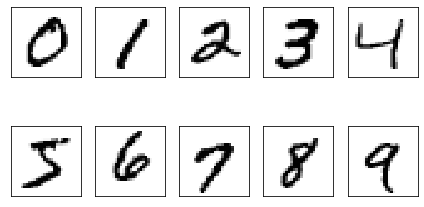

In [6]:
fig, ax = plt.subplots(nrows = 2, ncols= 5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28,28)
    ax[i].imshow(img, cmap='Greys' )

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

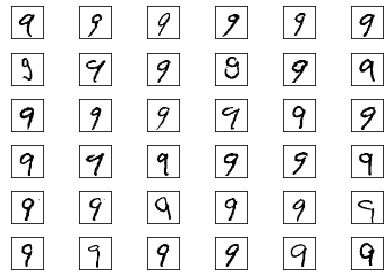

In [7]:
fig, ax = plt.subplots(nrows = 6, ncols= 6, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(36):
    img = X_train[y_train == 9][i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys' )

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [84]:
X_valid = X_train[55000:]
y_valid = y_train[55000:]

X_train = X_train[:55000]
y_train = y_train[:55000]

In [86]:

X_valid.shape

(5000, 784)

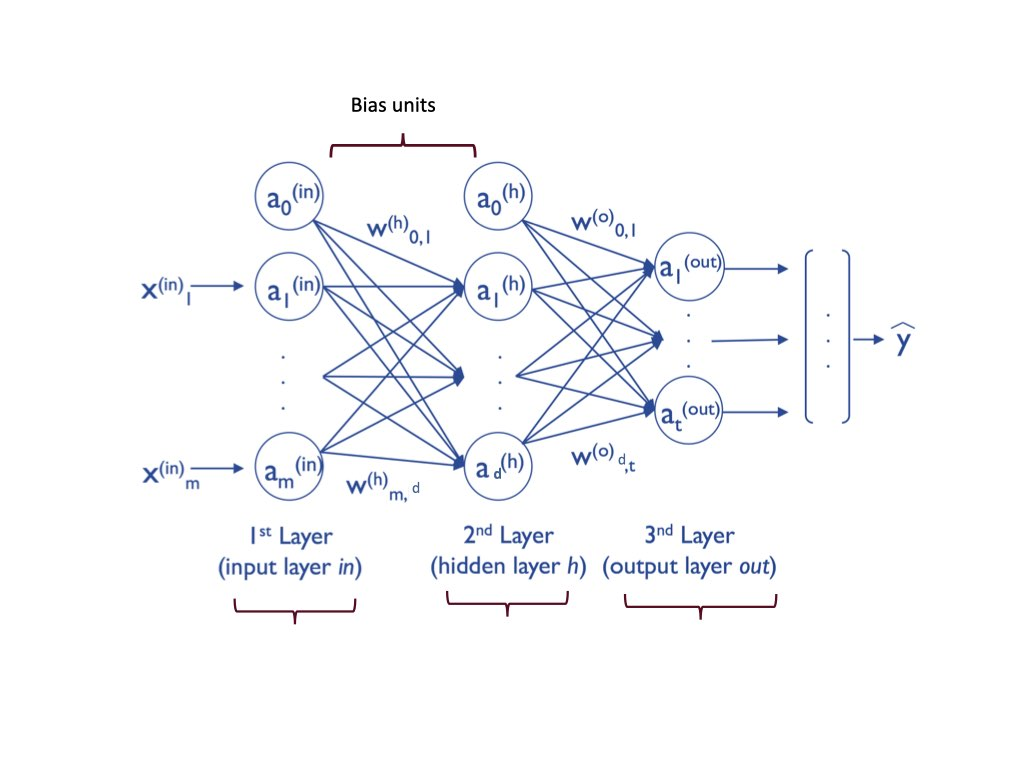

In [10]:
from IPython.display import Image
Image(filename='data/mlp.jpg')

In [93]:
# Parameters
n_hidden=200 # number of hidden units (2nd layer)
epochs=10 # number of epochs for training
eta=0.01 # learning rate
minibatch_size=100  # training using minibatchGD
seed=1 # seed for reproducibility
l2 = 0.01

random = np.random.RandomState(seed)
n_features = X_train.shape[1]
n_output = np.unique(y_train).shape[0]
#weight initialization

#input -> hidden
b_h = np.zeros(n_hidden)
w_h = random.normal(loc = 0.0, scale=0.1, size=(n_features,n_hidden))

#hidden -> output
b_out = np.zeros(n_output)
w_out = random.normal(loc = 0.0, scale=0.1, size=(n_hidden,n_output))

#one-hot codification
#ex: [0 1 0 0 0 0 0 0 0 0] -> Label 1
#ex: [1 0 0 0 0 0 0 0 0 0] -> Label 0

onehot = np.zeros((n_output, y_train.shape[0]))
for idx, val in enumerate(y_train.astype(int)):
    onehot[val, idx] = 1.

    
y_train_enc = onehot.T


In [95]:
epoch_strlen = len(str(epochs))  # for progress formatting
eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

#traininig

for i in range(epochs):
    #iterate over mini-batches
    indices = np.arange(X_train.shape[0])
    random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size +1, minibatch_size ):
        batch_idx = indices[start_idx:start_idx+minibatch_size]
        
        #Forward prop
        
        #step 1: dot product hidden layer: [100,784] dot [784,n_hidden]=[100,n_hidden]
        z_h = np.dot(X_train[batch_idx], w_h) + b_h
        #step 2 : activation hidden layer: Compute logistic function (sigmoid)
        a_h = 1. / (1. + np.exp(-z_h))
        #step 3 : dot product output layer: [100, n_hidden] dot [n_hidden, 10] = [100, 10]
        z_out = np.dot(a_h, w_out) + b_out
        #step 4: activation output layer
        a_out = 1. / (1. + np.exp(-z_out))
        
        
        #Backpropagation
        #Error vector in output layer
        #[100, 10]
        delta_out = a_out - y_train_enc[batch_idx]
        
        #Error term in the hidden layer
        sigmoid_derivative_h = a_h * (1. - a_h)
        delta_h = (np.dot(delta_out, w_out.T) * sigmoid_derivative_h)
        
        #Derivatives of cost function. output layer
        grad_w_out = np.dot(a_h.T, delta_out)
        grad_b_out = np.sum(delta_out, axis=0)
        
        #hidden layer
        grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
        grad_b_h = np.sum(delta_h, axis=0)

        
        # Regularization and weight updates
        delta_w_out = (grad_w_out + l2*w_out)
        delta_b_out = grad_b_out  # bias is not regularized
        w_out -= eta * delta_w_out
        b_out -= eta * delta_b_out


        delta_w_h = (grad_w_h + l2*w_h)
        delta_b_h = grad_b_h # bias is not regularized
        w_h -= eta * delta_w_h
        b_h -= eta * delta_b_h

    #evaluation after each epoch
    
    #forward propagation with all training set
    z_h = np.dot(X_train, w_h) + b_h
    a_h = 1. / (1. + np.exp(-z_h))
    z_out = np.dot(a_h, w_out) + b_out
    a_out = 1. / (1. + np.exp(-z_out))
    
    #compute cost
    L2_term = (l2 *(np.sum(w_h ** 2.) + np.sum(w_out ** 2.)))
    term1 = -y_train_enc * (np.log(a_out))
    term2 = (1. - y_train_enc) * np.log(1. - a_out)
    cost = np.sum(term1 - term2) + L2_term
    
    #prediction of train set
    y_train_pred = np.argmax(z_out, axis=1)
    
    #prediction of valid set
    z_h = np.dot(X_valid, w_h) + b_h
    a_h = 1. / (1. + np.exp(-z_h))
    z_out = np.dot(a_h, w_out) + b_out
    a_out = 1. / (1. + np.exp(-z_out))
    y_valid_pred = np.argmax(z_out, axis=1)
    
    train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
    valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])

    print('Epoch: %.2f | Cost: %.2f | Train/Valid Acc.: %.2f%%/%.2f%% '
                     % (int(i+1), cost,train_acc*100, valid_acc*100))
    sys.stderr.flush()

    eval_['cost'].append(cost)
    eval_['train_acc'].append(train_acc)
    eval_['valid_acc'].append(valid_acc)


    
    

Epoch: 1.00 | Cost: 13204.92 | Train/Valid Acc.: 96.55%/96.86% 
Epoch: 2.00 | Cost: 15397.92 | Train/Valid Acc.: 95.96%/96.32% 
Epoch: 3.00 | Cost: 12308.67 | Train/Valid Acc.: 96.93%/96.94% 
Epoch: 4.00 | Cost: 12900.57 | Train/Valid Acc.: 96.83%/96.78% 
Epoch: 5.00 | Cost: 10756.41 | Train/Valid Acc.: 97.37%/97.02% 
Epoch: 6.00 | Cost: 12050.96 | Train/Valid Acc.: 97.03%/96.84% 
Epoch: 7.00 | Cost: 10211.75 | Train/Valid Acc.: 97.61%/97.42% 
Epoch: 8.00 | Cost: 10203.62 | Train/Valid Acc.: 97.54%/97.30% 
Epoch: 9.00 | Cost: 11815.05 | Train/Valid Acc.: 96.92%/96.62% 
Epoch: 10.00 | Cost: 11456.58 | Train/Valid Acc.: 97.33%/96.90% 


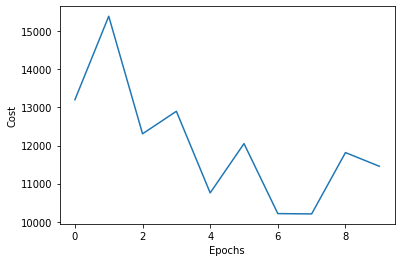

In [96]:
plt.plot(range(epochs), eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

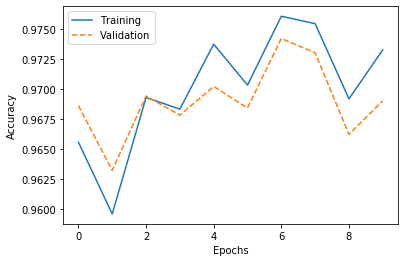

In [99]:
plt.plot(range(epochs), eval_['train_acc'], label='Training')
plt.plot(range(epochs), eval_['valid_acc'], label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [100]:
#prediction on the test set
z_h = np.dot(X_test, w_h) + b_h
a_h = 1. / (1. + np.exp(-z_h))
z_out = np.dot(a_h, w_out) + b_out
a_out = 1. / (1. + np.exp(-z_out))
y_test_pred = np.argmax(z_out, axis=1)

acc = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 96.32%


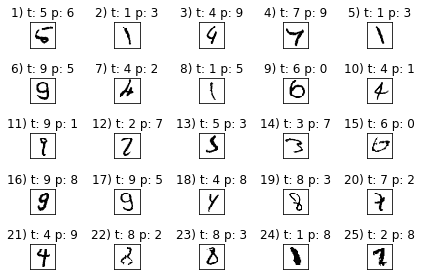

In [101]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()